<a href="https://colab.research.google.com/github/usman3721/Financial-sentiment-Analysis-with-deployement/blob/main/Financial_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading the Dataset
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Mentorness Intership/Project2/Financial Sentiment Analysis/data.csv')

In [ ]:
# Libraires needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Evaluation Metric Libraries
from sklearn.metrics import confusion_matrix, accuracy_score

## EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
df.describe


<bound method NDFrame.describe of                                                Sentence Sentiment
0     The GeoSolutions technology will leverage Bene...  positive
1     $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2     For the last quarter of 2010 , Componenta 's n...  positive
3     According to the Finnish-Russian Chamber of Co...   neutral
4     The Swedish buyout firm has sold its remaining...   neutral
...                                                 ...       ...
5837  RISING costs have forced packaging producer Hu...  negative
5838  Nordic Walking was first used as a summer trai...   neutral
5839  According shipping company Viking Line , the E...   neutral
5840  In the building and home improvement trade , s...   neutral
5841  HELSINKI AFX - KCI Konecranes said it has won ...  positive

[5842 rows x 2 columns]>

In [ ]:
# Checking for null values in the dataset
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

## This shows there is no null values in the dataset

In [ ]:
# Checking for duplicates in the dataset
df[df.duplicated()]

,Sentence,Sentiment
1825,Proha Plc ( Euronext :7327 ) announced today (...,neutral
1859,SSH Communications Security Corporation is hea...,neutral
2672,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
3272,The company serves customers in various indust...,neutral
3986,The issuer is solely responsible for the conte...,neutral
5342,The report profiles 614 companies including ma...,neutral


In [ ]:
duplicates=df[df.duplicated()]

In [ ]:
dropped_duplicates=df.drop_duplicates()

In [ ]:
dropped_duplicates.reset_index(drop=True)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5831,RISING costs have forced packaging producer Hu...,negative
5832,Nordic Walking was first used as a summer trai...,neutral
5833,"According shipping company Viking Line , the E...",neutral
5834,"In the building and home improvement trade , s...",neutral


In [ ]:
df=dropped_duplicates

## There is 6 duplicates in the dataset and all was remooved from the dataset

SO with our dataset has no null value

<Axes: xlabel='Sentiment', ylabel='count'>

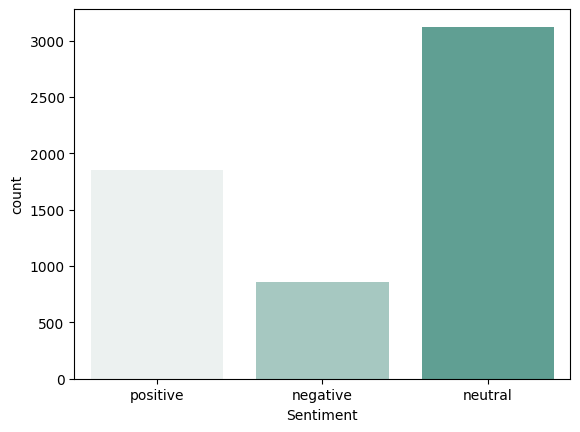

In [ ]:
import seaborn as sns
sns.countplot(data=df, x='Sentiment', palette='light:#5A9')

In [ ]:
df['Sentiment'].value_counts()

neutral     3124
positive    1852
negative     860
Name: Sentiment, dtype: int64

So our datat contains the total of 5842 records of which -
Neutral records are 3130 of 5842 = 53.57%
Positive records are 1852 of 5842 = 31.7%
negative records are 860 of 5842 = 14.72%

### FEATURE EMGINEERING(Text Preprocessing)

In [ ]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


These shows all the Word2Vec pretrained models available in gensim library. We will use 'word2vec-google-news-300' model  for it quality and generalization to convert our words to vectors. The dimension of each vectors will be 300x1.

In [ ]:
%%time
word2Vec_model= api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
CPU times: user 7min 22s, sys: 46.3 s, total: 8min 8s
Wall time: 9min 14s


Now we are going to define a function called 'sent_to_vec()'. The purpose of this function is to convert all the words in a sentance into vectors and take average of all these vectors so that the dimension of all the sentences is 300x1.

In [ ]:
def sent_to_vec(sent):
    vector_size = word2Vec_model.vector_size
    wv_res = np.zeros(vector_size)
    count = 1
    for word in sent:
        if word in word2Vec_model:
            count+=1
            wv_res = word2Vec_model[word]

    wv_res = wv_res/count
    return wv_res

Next, we define a function called 'text_preprocess()' to do pre-processing works like, stopword removal, converting to tokens, removing special characters, etc., from the input sentences.

In [ ]:
def text_preprocess(sent):
    # Removing the numbers, special characters, etc from the sentence and replacing them with " "
    sent = re.sub('[^a-zA-Z]',' ',sent)
    # Converting sentence into a spacy doc - which is a sequence of tokens
    doc = nlp(sent)
    # Lemmatization and lower casing the words
    tokens = [word.lemma_.lower().strip() for word in doc]
    # Removing stop words and punctuations
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

applying the token to the sentence using apply()

In [ ]:
df['tokens'] = df['Sentence'].apply(text_preprocess)
df.head()

<ipython-input-19-9a3f96157fa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['Sentence'].apply(text_preprocess)


,Sentence,Sentiment,tokens
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[, esi, low, , , , bk, real, possibility]"
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[quarter, , componenta, , s, net, sale, double..."
3,According to the Finnish-Russian Chamber of Co...,neutral,"[accord, finnish, russian, chamber, commerce, ..."
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sell, remain, , percen..."


Applying the sent_to_vec() thr sentence

In [ ]:
df['vectors'] = df['tokens'].apply(sent_to_vec)
df.head()

<ipython-input-20-19867b160c21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vectors'] = df['tokens'].apply(sent_to_vec)


,Sentence,Sentiment,tokens,vectors
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ...","[0.00860305, 0.0058826264, 0.004301525, 0.0099..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[, esi, low, , , , bk, real, possibility]","[0.003560384, 0.0234375, 0.014322917, 0.027832..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[quarter, , componenta, , s, net, sale, double...","[-0.006969105, 0.0076793325, -0.002141779, 0.0..."
3,According to the Finnish-Russian Chamber of Co...,neutral,"[accord, finnish, russian, chamber, commerce, ...","[-0.012858073, 0.0006154378, 0.012532552, 0.03..."
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sell, remain, , percen...","[0.0030235876, -0.0016714243, 0.0076998197, 0...."


Now we define a function called 'convert_output__to_num()' to convert the output feature i.e., Sentiment column into numbers.



In [ ]:
def convert_output_to_num(output):
    if output == 'positive':
        return 1
    elif output == 'negative':
        return 2
    else:
        return 0

In [ ]:
df['Sentiment'] = df['Sentiment'].apply(convert_output_to_num)
df.head()

<ipython-input-22-0ed92c1a1a42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].apply(convert_output_to_num)


,Sentence,Sentiment,tokens,vectors
0,The GeoSolutions technology will leverage Bene...,1,"[geosolutions, technology, leverage, benefon, ...","[0.00860305, 0.0058826264, 0.004301525, 0.0099..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",2,"[, esi, low, , , , bk, real, possibility]","[0.003560384, 0.0234375, 0.014322917, 0.027832..."
2,"For the last quarter of 2010 , Componenta 's n...",1,"[quarter, , componenta, , s, net, sale, double...","[-0.006969105, 0.0076793325, -0.002141779, 0.0..."
3,According to the Finnish-Russian Chamber of Co...,0,"[accord, finnish, russian, chamber, commerce, ...","[-0.012858073, 0.0006154378, 0.012532552, 0.03..."
4,The Swedish buyout firm has sold its remaining...,0,"[swedish, buyout, firm, sell, remain, , percen...","[0.0030235876, -0.0016714243, 0.0076998197, 0...."


In [ ]:
# Converting X and y to a list
X = df['vectors'].to_list()
y = df['Sentiment'].to_list()

In [ ]:
# Spliting into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=0)

### MODEL TRAINING

In [ ]:
models = {
    "Logistic Regression" : LogisticRegression(),
    "SVM" : SVC(),
    "Naive Bayes" : GaussianNB(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "KNN" : KNeighborsClassifier(),

}

In [ ]:
# Hyper Parameter tuning
%%time
params = {
    "Logistic Regression" : {
        "C" : [100, 10, 1.0, 0.1, 0.01],
        "penalty" : ['l1', 'l2']
    },
    "SVM" : {
        "C" : [0.1, 1, 10, 100, 1000],
        "gamma" : [1, 0.1, 0.01, 0.001, 0.0001],
        "kernel" : ['rbf']
    },
     "Naive Bayes" : {
        "var_smoothing" : np.logspace(0,-9, num=100)
     },

    "Decision Tree" : {
        "max_depth" : [3, 4, 5, 10, 15]
    },
    "Random Forest" : {
        "n_estimators" : [100, 200, 300, 400],

        "max_depth" : [3, 5, 10],
        "min_samples_leaf" : [1, 2, 4]
    },
    "KNN" : {
        'n_neighbors' : [5, 7, 9, 11, 13, 15],
        'weights' : ['uniform', 'distance'],
        'metric' : ['minkowski', 'euclidean', 'manhattan']
    },
}

CPU times: user 279 µs, sys: 0 ns, total: 279 µs
Wall time: 288 µs


In [ ]:
%%time
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    report = {}
    for i in range(len(list(models))):
        model = list(models.values())[i]
        para = param[list(models.keys())[i]]

        gs = GridSearchCV(model, para, cv=5)
        gs.fit(X_train, y_train)

        model.set_params(**gs.best_params_)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_model_score = accuracy_score(y_train, y_train_pred)
        test_model_score = accuracy_score(y_test, y_test_pred)

        report[list(models.keys())[i]] = test_model_score

    return report

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.7 µs


In [ ]:
%%time
model_report: dict = evaluate_models(
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, models=models, param=params)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

CPU times: user 38min 21s, sys: 20 s, total: 38min 41s
Wall time: 39min


In [ ]:
# Model Report Containing the accuracies of all the models
print(model_report)

{'Logistic Regression': 0.577054794520548, 'SVM': 0.5753424657534246, 'Naive Bayes': 0.5333904109589042, 'Decision Tree': 0.5539383561643836, 'Random Forest': 0.5625, 'KNN': 0.553082191780822}


Looking at the accuracy of the model we can say it's not the best model. But we can still make it more accurate by trying some more sets of hyperparameters OR Using Deep Learning Method which we will be suing Further.

In [ ]:
# To get best model score from dict
best_model_score = max(sorted(model_report.values()))
# To get best model name from dict
best_model_name = list(model_report.keys())[
    list(model_report.values()).index(best_model_score)
]
best_model = models[best_model_name]
print(best_model)

LogisticRegression(C=10)


In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
cm=confusion_matrix(y_test, y_pred)

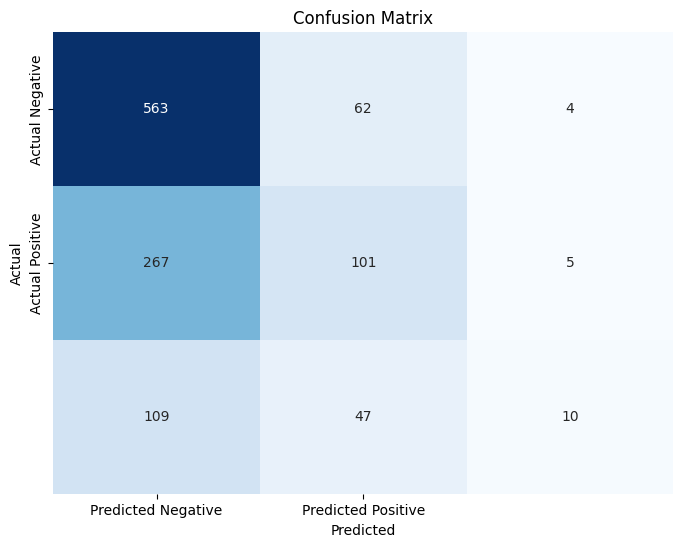

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
filename = 'financial_sentiment_analysis_model.pickle'
pickle.dump(best_model, open(filename, 'wb'))

## PREDICTING ON NEW DATASET

In [ ]:
input="The GeoSolutions team further provides an intriguing new technology combining GPS and Mobile-based technologies together with Internet-based social networking "

In [ ]:
preprocessed_input = text_preprocess(input)
vector_input = sent_to_vec(preprocessed_input)

In [ ]:
# load the saved model if you want
# loaded_model = pickle.load(open(filename, "rb"))
pout = best_model.predict(vector_input.reshape(1,-1))
output = 'positive' if pout==1 else 'neutral' if pout==0 else 'negative'
print(output)

neutral
